In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api
import ISLP.models
import sklearn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

# 最小绝对收缩与选择算子（LASSO）回归

## 概述
本 Notebook 探讨如何在 "Boston" 数据集上使用最小绝对收缩与选择算子（LASSO）回归方法来剔除无关协变量。您将学习如何：

- 使用 scikit-learn 库提供的 LASSO 实现。
- 评估 LASSO 的性能并解释输出结果。
- 使用交叉验证探索 LASSO 模型预测的稳定性。
- 使用交叉验证选择最佳的 LASSO 参数。
- 绘制 LASSO 路径，以深入分析相关协变量。

## 加载演示数据

我们将从 ISLP 包中加载 "Boston" 示例数据集。该数据集来自 Harrison 和 Rubinfeld 于 1978 年进行的一项研究，题为《享乐价格与清洁空气的需求》。数据集中包含了波士顿 506 个郊区的信息。

In [25]:
data_boston = ISLP.load_data("Boston")

## 包含多个协变量的数据

我们将构建 `x_matrix`，其中包含数据集中的所有协变量，就像我们在之前的练习中所做的那样。

In [ ]:
data_num_of_rows = data_boston["medv"].shape[0]
x_matrix = data_boston.drop(columns=["medv"])
x_matrix.insert(loc=0, column="intercept", value=np.ones(data_num_of_rows))

y = data_boston["medv"]

x_matrix = x_matrix.iloc[:, :13]
print(x_matrix.shape)

results = statsmodels.api.OLS(y, x_matrix).fit()
results_summary = ISLP.models.summarize(results)
results_summary

(506, 13)


,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


## 什么是 LASSO

LASSO 是一种线性回归方法，它结合了正则化技术，以提高统计模型的预测准确性和可解释性。与普通线性回归不同，LASSO 在损失函数中加入了一个与系数绝对值大小等价的惩罚项。此惩罚项促使模型将不太重要特征的系数缩减为零，从而实现特征选择。

LASSO 的主要作用是通过关注最重要的预测变量来构建更简单、更具可解释性的模型。这一独特特性使其在预测变量数量相对于观测数较多或预测变量之间存在多重共线性时尤其有用。通过控制模型的复杂性，LASSO 可以帮助防止过拟合，是多种回归任务中的一种重要工具。

## 实现

我们将利用 scikit-learn 中的 LASSO 实现。scikit-learn 库中的不同函数使用随机数生成器（RNG）进行诸如数据洗牌或随机化的操作。我们将使用并输入相同的随机数生成器“种子”（一个正整数），以确保所有机器上的结果具有可重复性。我们将进行以下步骤：

- 将数据分为训练集和测试集。
- 实例化一个带有正则化参数 alpha = 0.1 的 Lasso 模型。该参数控制正则化的强度（更大的 alpha 值会使系数更加稀疏）。在接下来的部分中，我们将深入探讨 alpha 值的选择。
- 在训练数据上拟合 LASSO 模型。
- 为测试集预测响应值。
- 计算均方误差（MSE）以评估 LASSO 模型的性能。

In [ ]:
seed = 0

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x_matrix, y, test_size=0.3, random_state=seed
)

lasso = Lasso(alpha=0.1)

lasso.fit(x_train, y_train)

y_pred = lasso.predict(x_test)

model_mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {model_mse}")

## MSE 的解读

我们可以从均方误差（MSE）中理解到什么？是否可以判断模型“好”或“坏”？

判断 MSE 的“好”或“坏”取决于与特定问题相关的几个因素，包括数据背景、目标变量的范围和模型的用途。有一些策略可以帮助我们做出决策：

### 1. 与基准模型比较
我们将首先将模型的 MSE 与简单的基准模型进行比较。一个常见的基准是均值模型，它总是预测目标变量的平均值：

In [30]:
y_mean_pred = np.mean(y_train)
baseline_model = [y_mean_pred] * len(y_test)
baseline_mse = mean_squared_error(y_test, baseline_model)

print(f"Baseline MSE: {baseline_mse}")
print(f"Model MSE: {model_mse}")  # Replace with your model's MSE

Baseline MSE: 83.76673764512785
Model MSE: 29.970835050383428


**解释**：由于模型的 MSE 远低于基准模型，说明模型比简单的朴素方法更好地捕捉了数据中的模式。

### 2. 考虑目标变量的尺度
**相对 MSE**：MSE 是一个依赖于尺度的指标，意味着它依赖于目标变量的大小。一个“好”的 MSE 应该相对于目标变量的方差较小。您认为它是较小还是较大？

In [31]:
y_variance = np.var(y_test)
print(f"Variance of Target: {y_variance}")
print(f"Model MSE: {model_mse}")

Variance of Target: 83.26550164473684
Model MSE: 29.970835050383428


### 3. 交叉验证性能
**一致性**：如果我们进行交叉验证，可以检查 MSE 在不同折叠间的一致性。一个好的模型应当在不同数据分割中保持相对稳定的 MSE。

In [ ]:
from sklearn.model_selection import cross_val_score

num_of_cross_validation_folds = 5

mse_scores = cross_val_score(
    lasso,
    x_train,
    y_train,
    scoring="neg_mean_squared_error",
    cv=num_of_cross_validation_folds,
)
print(f"Cross-validated MSE: {-mse_scores}")
print(f"Cross-validated MSE: {-mse_scores.mean()}")
print("Standard Deviation of MSE: ", np.std(mse_scores))

Cross-validated MSE: [19.9730343  22.85914062 19.43857603 36.90436468 20.86996049]
Cross-validated MSE: 24.00901522604972
Standard Deviation of MSE:  6.552006872445729


这看起来不是世界上最稳定的 MSE。不过公平地说，我们的原始数据集中约有 500 行，取其中的三分之一作为训练集（500/3 ≈ 170），然后将其进一步分为五组进行交叉验证，每组约有 35 个观测值。可以说，对于如此少量的数据，MSE 结果已经相对稳定。因此，我们可以认定该模型为“良好”模型。

## LASSO 输出

既然我们已经确定 LASSO 在此设置下表现良好，现在让我们更仔细地查看其输出。我们将打印拟合的协变量系数，并将其绘制出来以便更好地观察。

               coef
intercept  0.000000
crim      -0.113621
zn         0.048136
indus     -0.048212
chas       1.157203
nox       -0.000000
rm         3.652720
age       -0.019827
dis       -1.251815
rad        0.180588
tax       -0.013104
ptratio   -0.815921
lstat     -0.552489


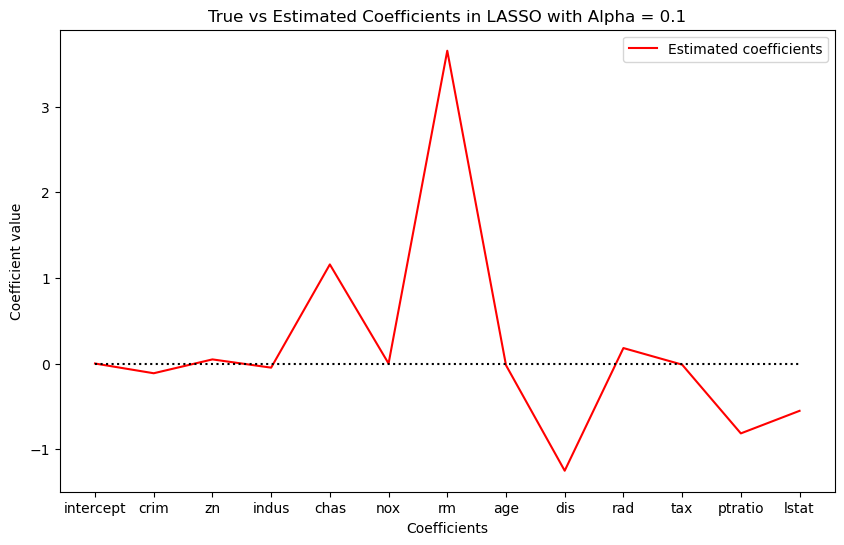

In [ ]:
colnames = x_matrix.columns
lasso_res = pd.DataFrame({"coef": lasso.coef_}, index=colnames)
print(lasso_res)

plt.figure(figsize=(10, 6))
# plt.plot(true_coefficients, 'b', label='True coefficients')
plt.plot(colnames, lasso.coef_, "r", label="Estimated coefficients")
plt.plot(colnames, np.zeros_like(colnames), "k:")
plt.legend()
plt.xlabel("Coefficients")
plt.ylabel("Coefficient value")
plt.title("True vs Estimated Coefficients in LASSO with Alpha = 0.1")
plt.show()

LASSO 输出显示，“截距”（这是显而易见的）和“nox”变量不会影响“medv”输出。LASSO 的输出取决于正则化参数“alpha”。在分析开始时，我们将其设置为 0.1。但，

- 这个值控制什么？
- 如何判断是否有其他更合适的值？

我们可以遍历不同的 alpha 值范围，并使用交叉验证选择最优的 alpha。

Optimal Alpha: 0.0001
Cross-validated MSE: [20.51536838 23.20607416 18.76826419 35.04524105 18.53151934]
Cross-validated MSE: 23.21329342407055
Standard Deviation of MSE:  6.147375533231202
                coef
intercept   0.000000
crim       -0.122006
zn          0.045088
indus       0.007095
chas        2.667824
nox       -16.920104
rm          3.792122
age        -0.007892
dis        -1.524541
rad         0.223864
tax        -0.011168
ptratio    -0.994122
lstat      -0.510744


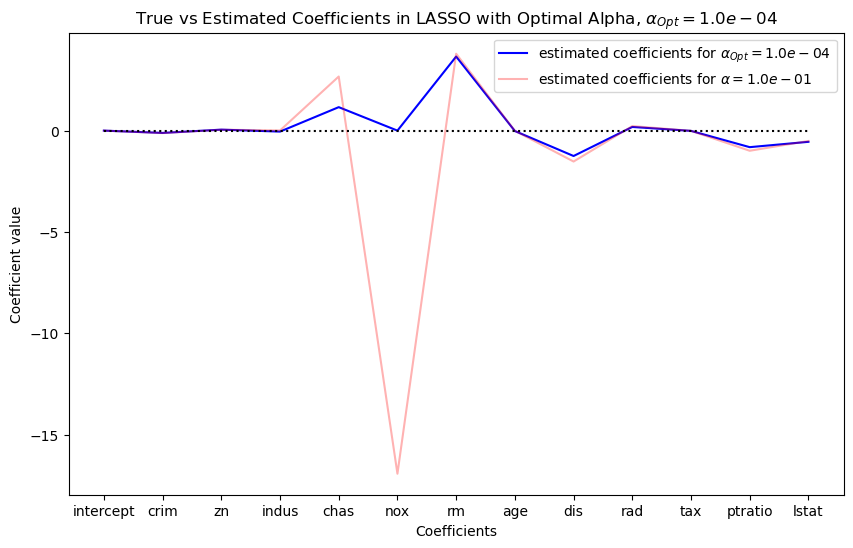

In [ ]:
alpha_range = np.logspace(-4, 0, 50)

lasso_cv = LassoCV(
    alphas=np.logspace(-4, 0, 50), cv=num_of_cross_validation_folds, random_state=seed
)
lasso_cv.fit(x_train, y_train)

optimal_alpha = lasso_cv.alpha_
print(f"Optimal Alpha: {optimal_alpha}")

y_pred_cv = lasso_cv.predict(x_test)

mse = mean_squared_error(y_test, y_pred_cv)
mse_scores_cv = cross_val_score(
    lasso_cv,
    x_train,
    y_train,
    scoring="neg_mean_squared_error",
    cv=num_of_cross_validation_folds,
)
print(f"Cross-validated MSE: {-mse_scores_cv}")
print(f"Cross-validated MSE: {-mse_scores_cv.mean()}")
print("Standard Deviation of MSE: ", np.std(mse_scores_cv))

lasso_cv_res = pd.DataFrame({"coef": lasso_cv.coef_}, index=colnames)
print(lasso_cv_res)

# Plot the true vs estimated coefficients
plt.figure(figsize=(10, 6))
plt.plot(
    colnames,
    lasso.coef_,
    "b",
    label=rf"estimated coefficients for $\alpha_{{Opt}} = {optimal_alpha:.1e}$",
)
plt.plot(
    colnames,
    lasso_cv.coef_,
    "r",
    alpha=0.3,
    label=rf"estimated coefficients for $\alpha ={0.1:.1e}$",
)
plt.plot(colnames, np.zeros_like(colnames), "k:")
plt.legend()
plt.xlabel("Coefficients")
plt.ylabel("Coefficient value")
plt.title(
    rf"True vs Estimated Coefficients in LASSO with Optimal Alpha, $\alpha_{{Opt}} = {optimal_alpha:.1e}$"
)
plt.show()

**解释**：对训练集中不同 alpha 值的交叉验证揭示了新的信息，同时也带来了更多问题：

1. 哪些协变量最适合用于建模？
2. 为什么结果发生了变化？交叉验证检查告诉我们，最佳的 LASSO alpha 值是 0.0001，而不是我们最初使用的 0.1。
3. 为什么在之前的分析中 "nox" 变量未作为相关协变量出现？

我们将打印 LASSO 输出的排序值，以找出最相关和最不相关的协变量。

In [ ]:
print(lasso_cv_res.sort_values(by="coef", key=lambda x: x.abs()))

                coef
intercept   0.000000
indus       0.007095
age        -0.007892
tax        -0.011168
zn          0.045088
crim       -0.122006
rad         0.223864
lstat      -0.510744
ptratio    -0.994122
dis        -1.524541
chas        2.667824
rm          3.792122
nox       -16.920104


"indus" 和 "age" 是无关的协变量。您是否还记得在练习开始时这些变量的 p 值？该结果是否与 LASSO 输出相符？

根据我们设定的阈值，我们还可以排除其他变量。例如，如果我们不想在建模中使用系数小于 0.1 的协变量，可以排除 "tax" 和 "zn" 变量。

最后，让我们看看在不同 alpha 值下结果的变化情况：

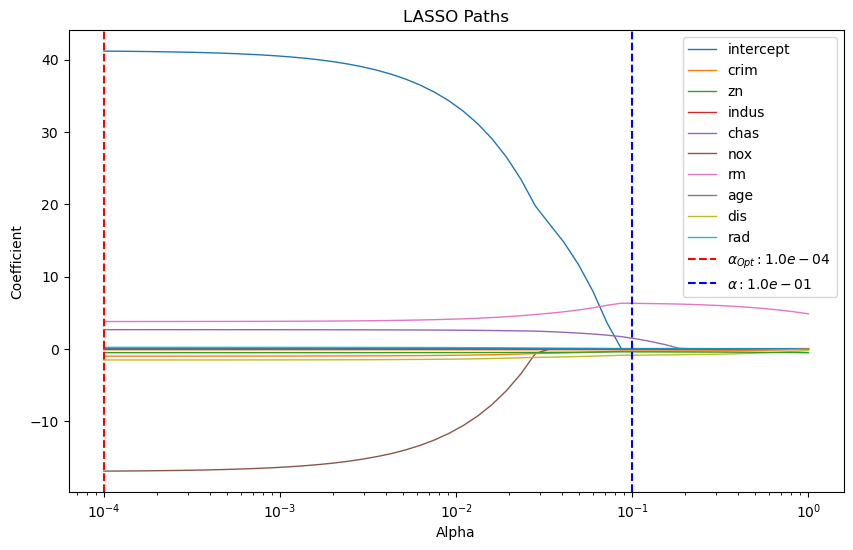

In [ ]:
from sklearn.linear_model import lasso_path

alphas_lasso, coefs_lasso, _ = lasso_path(
    x_train, y_train, alphas=alpha_range, max_iter=5000
)

plt.figure(figsize=(10, 6))
for i in range(coefs_lasso.shape[0]):
    plt.plot(
        alphas_lasso, coefs_lasso[i], label=f"{colnames[i]}" if i < 10 else "", lw=1
    )

plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Coefficient")
plt.title("LASSO Paths")
plt.axvline(
    optimal_alpha,
    linestyle="--",
    color="r",
    label=rf"$\alpha_{{Opt}}: {optimal_alpha:.1e}$",
)
plt.axvline([0.1], linestyle="--", color="b", label=rf"$\alpha: {0.1:.1e}$")
plt.legend(loc="best")
plt.show()

### Can you answer questions 2 and 3?